In [1]:
import sys
sys.path.append("/home/missinguser/CSE/single-stage-opt/hybrid_tokamak/laptop/")
import latexplot
latexplot.set_cmap(4)
import os
from typing import Literal
import numpy as np
import matplotlib.pyplot as plt
import simsopt
from simsopt import mhd
from simsopt import geo
import json
from scipy.spatial.distance import cdist
from scipy.stats import linregress
from scipy.io import netcdf
import scipy.ndimage.filters
import warnings
from pathlib import Path
import asyncio
from concurrent.futures import ThreadPoolExecutor
from simsopt.configs import get_QUASR_data
from simsopt.mhd.vmec_diagnostics import vmec_compute_geometry

sys.path.append("/home/missinguser/CSE/single-stage-opt/")
sys.path.append("/home/missinguser/CSE/regcoil")
from replicate_lgradb.find_single_l import find_regcoil_distance


MAX_SVD_VALS = 40
SINGLE_STAGE_PATH = Path.home() / "single-stage-opt/"


def coil_surf_distance(curves, lcfs) -> np.ndarray:
    pointcloud1 = lcfs.gamma().reshape((-1, 3))
    distances = [np.min(cdist(pointcloud1, c.gamma()), axis=0) for c in curves]
    return np.array(distances).T


def compute_coil_surf_dist(simsopt_filename):
    surfaces, coils = simsopt.load(simsopt_filename)
    lcfs = surfaces[-1].to_RZFourier()

    curves = [c.curve for c in coils]
    return coil_surf_distance(curves, lcfs)


def fit_exponential_rate(sequence, title):
    x = np.linspace(0, 1, len(sequence))
    # plt.semilogy(x, sequence)
    fit = np.polyfit(x, np.log(sequence), 1)
    # plt.semilogy(x, np.exp(np.polyval(fit, x)))
    # plt.title(title)
    # plt.show()
    return fit


def compare_bdistrib(simsopt_name):
    filepath = f"{SINGLE_STAGE_PATH}/replicate_lgradb/tmp/dist05/bdistrib_out.{simsopt_name.replace('.json','.nc')}"
    # Some fits of the exponential decay, take a look at compareSingularValuesPlot.py and bdistrib_util.py

    bdistrib_variables = [
        "Bnormal_from_const_v_coils_inductance",
        "Bnormal_from_const_v_coils_transfer",
        # "svd_s_transferMatrix",
        # "svd_s_inductance_plasma_middle",
    ]
    fit_types = [
        "log_linear",
        #  "value",
        #  "windowed_upper_bound"
    ]
    fits = {}
    with netcdf.netcdf_file(filepath, "r", mmap=False) as f:
        for key in bdistrib_variables:
            vararray = f.variables[key][()].flatten()
            vararray = np.abs(vararray)  # [:MAX_SVD_VALS]
            for fit_type in fit_types:
                if fit_type == "value":
                    fit_val = np.max(np.log(vararray))
                elif fit_type == "log_linear":
                    # Only take the 0 element (slope) of the fit
                    fit_val = fit_exponential_rate(vararray, key)[0]
                else:
                    windowed_array = scipy.ndimage.filters.maximum_filter1d(
                        vararray, size=16
                    )
                    fit_val = fit_exponential_rate(windowed_array, key)[0]
                fits[key + fit_type] = fit_val
    print(list(fits.keys()))
    return fits


def vs_plot(x_data, y_data, labels=None):
    x_vals, x_label = x_data
    y_vals, y_label = y_data
    title = x_label + " vs " + y_label

    if len(np.shape(y_vals)) >= 2:
        y_vals = np.array(y_vals).T
    elif len(np.shape(y_vals)) == 1:
        y_vals = np.reshape(y_vals, (1,) + np.shape(y_vals))

    # Linear fit
    # TODO this Fails because some values are inf!!
    for i, y in enumerate(y_vals):
        plt.scatter(x_vals, y, label=title if labels is None else labels[i])
        reg = linregress(x_vals, y)
        plt.axline(
            xy1=(0, reg.intercept),
            slope=reg.slope,
            color="k",
            label=f"Linear fit {i}: $R^2$ = {reg.rvalue:.2f}",
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if np.min(y_vals) >= 0:
        plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(left=0)
    plt.grid(True)
    plt.legend()


In [2]:

regcoil_plot = True
bdistrib_plot = True


import pandas as pd
df:pd.DataFrame = pd.read_pickle("../quasr_coil_check/QUASR_db/QUASR_08072024.pkl")

# Filter df by constant number of coils
df = df[df["nc_per_hp"] * df["nfp"] == 6]
df = df.sample(n=15, replace=False, random_state=10)
print(df.columns)
print(df["ID"])


LgradB_keyed = {}
coil_surf_dist = {}

def getLgradB(vmec:mhd.Vmec):
    vmec.run()
    s = [0.75, 0.96]
    ntheta = 64
    nphi = 64
    theta = np.linspace(0, 2 * np.pi, ntheta, endpoint=False)
    phi = np.linspace(0, 2 * np.pi / vmec.wout.nfp, nphi, endpoint=False)
    data = vmec_compute_geometry(vmec, s, theta, phi)

    gradB = np.array([[data.grad_B__XX, data.grad_B__YX, data.grad_B__ZX],
                      [data.grad_B__XY, data.grad_B__YY, data.grad_B__ZY],
                      [data.grad_B__XZ, data.grad_B__YZ, data.grad_B__ZZ]])
    assert np.shape(gradB)[:2] == (3, 3)
            
    return {
        "grad(B)": gradB,
        "|B|": data.modB
    }

desc_outputs = list(
    filter(lambda x: x.endswith("_output.h5"), os.listdir()))
ids = [ 50638,
        50646,
        50695,
        30620,
        30661,
        30664,
        30812,
        70800,
        887713,
        672363,
        18874,
        19047,
        19098,
        19112,
        19152,
        19266,
        19267,
        19371,
        19377,
        19379,
        19384 ]
ids = df["ID"].tolist()

vmec = mhd.Vmec(verbose=False)
# vmec.indata.mpol = 6
# vmec.indata.ntor = 5
# vmec.indata.niter_array[:3] = [1000,2500, 4000]
# vmec.indata.ns_array[:3] = [6, 13, 31]
# vmec.indata.ftol_array[:3] = [1e-5, 1e-7, 1e-10]


def get_QUASR_data_sync(idx, style):
    # Your original synchronous function
    return get_QUASR_data(idx, style)

async def fetch_data(idx, loop, executor):
    surfs, coils = await loop.run_in_executor(executor, get_QUASR_data_sync, idx, 'quasr-style')
    return idx, surfs, coils
    # try:
    # # Network error
    # except ValueError as e:
    #     print(f"Network error with {idx}: {e}")
    #     return idx, None, None


loop = asyncio.get_event_loop()
executor = ThreadPoolExecutor()

tasks = [fetch_data(idx, loop, executor) for idx in ids]
results = await asyncio.gather(*tasks)
results = list(filter(lambda x: x[1] is not None, results))


Index(['qs_error', 'total_coil_length', 'total_coil_length_threshold',
       'mean_iota', 'max_kappa', 'max_msc', 'nc_per_hp', 'nfp', 'aspect_ratio',
       'ID', 'minor_radius', 'Nsurfaces', 'volume', 'helicity'],
      dtype='object')
39     927187
84     617725
47    2253513
7       56805
Name: ID, dtype: int64
Configuration with ID 0056805 downloaded successfully
Configuration with ID 2253513 downloaded successfully
Configuration with ID 0927187 downloaded successfully
Configuration with ID 0617725 downloaded successfully


In [29]:
vmecs = {}
regcoil_distances = {}
for idx, surfs, coils in results:
    s : geo.SurfaceRZFourier = surfs[-1].to_RZFourier().copy()

    # If the configurations are all scaled to the same major radius instead of minor radius, the results that follow are not qualitatively different
    # scaling = 1.704 / s.minor_radius()
    # s.rc_array *= scaling
    # s.zs_array *= scaling
    scaling = 1

    vmec.boundary = s
    vmec.indata.nfp = vmec.boundary.nfp

    try:
        vmec.run()
        s = [0.75, 0.96]
        ntheta = 64
        nphi = 64
        theta = np.linspace(0, 2 * np.pi, ntheta, endpoint=False)
        phi = np.linspace(0, 2 * np.pi / vmec.boundary.nfp, nphi, endpoint=False)
        data = vmec_compute_geometry(vmec, s, theta, phi)
        B0 = np.mean(data.modB)
        # print("B0", B0, "scaling", scaling)
        vmec.indata.phiedge = 5.865 * vmec.indata.phiedge / B0
        vmec.recompute_bell()
        vmec.run()
        data = vmec_compute_geometry(vmec, s, theta, phi)
        vmecs[idx] = data
        B0 = np.mean(data.modB)
        # plt.imshow(data.modB[-1])
        # plt.colorbar()
        # plt.show()
        regcoil_distances[ f"{idx:07d}" ] = find_regcoil_distance(vmec, idx)
        print("B0", B0, "scaling", scaling, "Lregcoil", regcoil_distances[ f"{idx:07d}" ])
    except Exception as e:
        print(f"VMEC didn't converge! Error with {idx}: {str(e)}")
        continue

# Try to run REGCOIL
# try:
#     with open("all_results.json") as f:
#         regcoil_distances = json.load(f)
#         for key in regcoil_distances.keys():
#             regcoil_distances[key] /= 5
# except Exception as e:
#     warnings.warn(e.__str__())
#     regcoil_plot = False

VMEC didn't converge! Error with 927187: VMEC did not converge. ierr=14
B0 5.865000000002222 scaling 1 Lregcoil 2.294117822652898
B0 5.865000000103009 scaling 1 Lregcoil inf
B0 5.864999999998874 scaling 1 Lregcoil 8.47245817469241


Loading 0927187
Loading 0617725
0.49261525931807837
0617725 has minimum filament coil distance 0.32257549281134545
Loading 2253513
0.5427832462701675
2253513 has minimum filament coil distance 0.3084654712094634
Loading 0056805
0.44262795633696284
0056805 has minimum filament coil distance 0.22258396791161061


/home/missinguser/miniconda3/envs/spec_wrapper/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


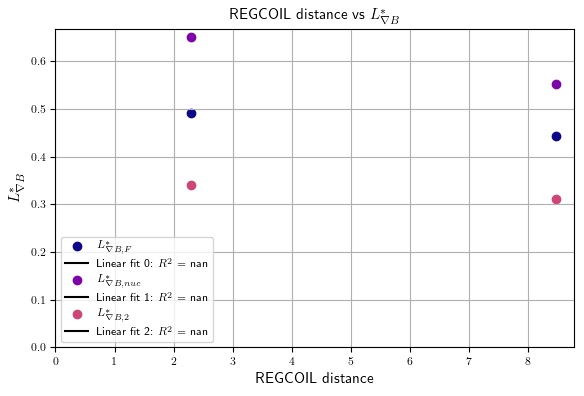

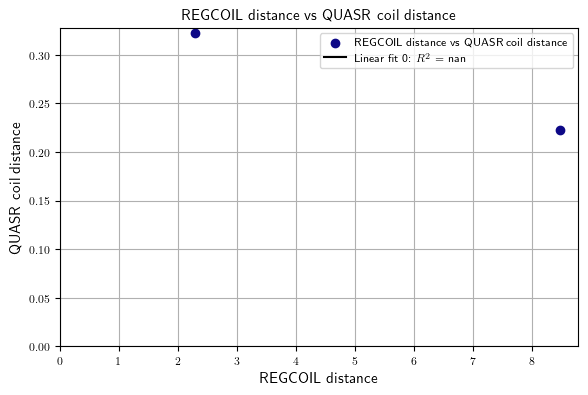

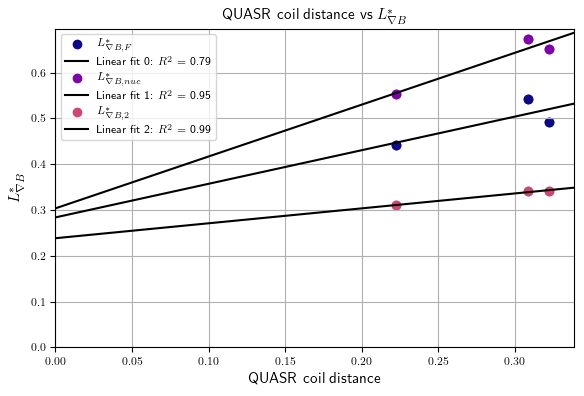

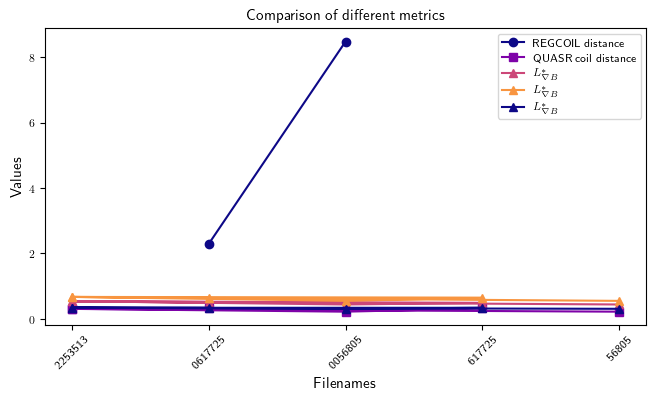

In [32]:
if __name__ == "__main__":
    for idx, surfs, coils in results:
        filename =  f"{idx:07d}" 
        print("Loading", filename)
        vmec.boundary = surfs[-1]
        vmec.indata.nfp = vmec.boundary.nfp
        # vmec.indata.mpol = 6
        # vmec.indata.ntor = 5
        # vmec.run()
        # vmec.recompute_bell()
        # vmec.indata.mpol = 10
        # vmec.indata.ntor = 10
        try:
            # computed = getLgradB(vmec)
            computed = vmecs[idx]
        except simsopt._core.util.ObjectiveFailure as e:
            print(f"VMEC didn't converge! Error with {idx}: {e}")
            continue 
        except KeyError:
            # VMEC didn't converge for this configuration, so its not a valid result
            continue

        # LgradBs = computed["L_grad(B)"]
        gradB = np.array([[computed.grad_B__XX, computed.grad_B__YX, computed.grad_B__ZX],
                          [computed.grad_B__XY, computed.grad_B__YY, computed.grad_B__ZY],
                          [computed.grad_B__XZ, computed.grad_B__YZ, computed.grad_B__ZZ]])
        LgradBs = (
            np.sqrt(2)
            * computed.modB
            / np.linalg.norm(gradB, ord="fro", axis=(0, 1))
        )
        LgradBnucs = (
            np.sqrt(2)
            * computed.modB
            / np.linalg.norm(gradB, ord="nuc", axis=(0, 1))
        )
        LgradB2s = (
            np.sqrt(2)
            * computed.modB
            / np.linalg.norm(gradB, ord=2, axis=(0, 1))
        )
        LgradB = np.min(LgradBs)
        print(LgradB)

        # REGCOIL distance
        simsopt_name = filename.replace("input.", "serial").replace(
            "_output.h5", ".json"
        )
        LgradB_keyed[simsopt_name] = np.array(
            [LgradB, np.min(LgradB2s), np.min(LgradBnucs)]
        )

        # The distances here were verified with the QUASR database GUI and are correct.
        # simsopt_path = f"{SINGLE_STAGE_PATH}/quasr_coil_check/QUASR_db/simsopt_serials/{simsopt_name[6:10]}/{simsopt_name}"
        coil_surf_dist[simsopt_name] = coil_surf_distance([c.curve for c in coils], surfs[-1]) #compute_coil_surf_dist(simsopt_path) 
        print(
            simsopt_name,
            "has minimum filament coil distance",
            np.min(coil_surf_dist[simsopt_name]),
        )

        # Only plot all individual equilibria for small datasets
        if LgradB < 0.05:#! or len(desc_outputs) <= 5:
            latexplot.set_cmap(len(coils))
            latexplot.figure()
            cross = vmec.boundary.cross_section(0, thetas=128)
            plt.subplot(2, 2, 1)
            plt.plot(cross[:,0], cross[:,2], label=f"{filename}  LgradB={LgradB}")
            cross = vmec.boundary.cross_section(np.pi/2, thetas=128)
            plt.plot(cross[:,1], cross[:,2], label=f"{filename}  LgradB={LgradB}")
            plt.subplot(2, 2, 2)
            plt.imshow(LgradBs[-1]) 
            plt.colorbar()
            plt.subplot(2, 2, 4)
            plt.imshow(LgradBs[0]) 
            plt.colorbar()


            # desc.plotting.plot_2d(eq, "L_grad(B)", ax=ax[0, 1], cmap="jet_r")
            # desc.plotting.plot_2d(eq, "L_grad(B)", ax=ax[0, 1], cmap="jet_r")

            if regcoil_plot:
                plt.hlines(
                    LgradB,
                    0,
                    1,
                    linestyles="dashed",
                )
                plt.hlines(
                    regcoil_distances[filename], 
                    0,
                    1,
                )
                plt.set_ylim(bottom=0)
                plt.legend(
                    ["$L^*_{\\nabla B}$", "Coil winding surf. dist."])

            # QUASR Filament coil distance
            plt.subplot(2, 2, 3)
            plt.plot(coil_surf_dist[simsopt_name], label="coil")
            plt.hlines(
                LgradB, 0, coil_surf_dist[simsopt_name].shape[0], linestyles="dashed"
            )
            plt.title("Filament coil distance")
            plt.legend()
            plt.ylim(bottom=0)

            plt.suptitle(filename)
            latexplot.savenshow(filename)

    #########################

    # Extract filenames and corresponding values for plotting
    filenames = list(LgradB_keyed.keys())
    if regcoil_plot:
        bothLgradBandRegcoil = list(set(LgradB_keyed.keys()).intersection(regcoil_distances.keys()))
        regcoil_vals = ([regcoil_distances[f] for f in bothLgradBandRegcoil], "REGCOIL distance")

        LgradB_vals = ([LgradB_keyed[f] for f in bothLgradBandRegcoil], "$L^*_{\\nabla B}$") 
        coil_min_vals = (
            [np.min(coil_surf_dist[f]) for f in bothLgradBandRegcoil],
            "QUASR coil distance",
        )
        latexplot.figure()
        vs_plot(regcoil_vals, LgradB_vals, ["$L^*_{\\nabla B, F}$", "$L^*_{\\nabla B, nuc}$", "$L^*_{\\nabla B, 2}$"])
        latexplot.figure()
        vs_plot(regcoil_vals, coil_min_vals)

    LgradB_vals = ([LgradB_keyed[f] for f in filenames], "$L^*_{\\nabla B}$") 
    if bdistrib_plot:
        try:
            Bdistrib_vals = (
                [list(compare_bdistrib(f).values()) for f in filenames],
                "efficient fields seqence",
            )
        except Exception as e:
            warnings.warn(e.__str__())
            bdistrib_plot = False

    coil_min_vals = (
        [np.min(coil_surf_dist[f]) for f in filenames],
        "QUASR coil distance",
    )

    latexplot.set_cmap(4)

    #########################
    latexplot.figure()
    vs_plot(coil_min_vals, LgradB_vals, ["$L^*_{\\nabla B, F}$", "$L^*_{\\nabla B, nuc}$", "$L^*_{\\nabla B, 2}$"])

    if bdistrib_plot:
        latexplot.figure()
        vs_plot(
            coil_min_vals,
            Bdistrib_vals,
            [
                "Bnormal_from_const_v_coils_inductancelog_linear",
                # "Bnormal_from_1_over_R_field_inductancevalue",
                # "Bnormal_from_1_over_R_field_inductancewindowed_upper_bound",
                "Bnormal_from_const_v_coils_transferlog_linear",
                # "Bnormal_from_1_over_R_field_transfervalue",
                # "Bnormal_from_1_over_R_field_transferwindowed_upper_bound",
                # "svd_s_transferMatrixlog_linear",
                # "svd_s_transferMatrixvalue",
                # "svd_s_transferMatrixwindowed_upper_bound",
                # "svd_s_inductance_plasma_middlelog_linear",
                # "svd_s_inductance_plasma_middlevalue",
                # "svd_s_inductance_plasma_middlewindowed_upper_bound",
            ],
        )

        if regcoil_plot:
            latexplot.figure()
            vs_plot(
                regcoil_vals,
                Bdistrib_vals,
                [
                    "Bnormal_from_const_v_coils_inductancelog_linear",
                    "Bnormal_from_const_v_coils_transferlog_linear",
                ],
            )

    # Plot over filenames: regcoil_distances, filament coil distance, L*_{\nabla B}
    latexplot.figure()

    if regcoil_plot:
        plt.plot(bothLgradBandRegcoil, regcoil_vals[0], marker="o", label=regcoil_vals[1])
    plt.plot(filenames, coil_min_vals[0], marker="s", label=coil_min_vals[1])
    plt.plot(filenames, LgradB_vals[0], marker="^", label=LgradB_vals[1])
    plt.xlabel("Filenames")
    plt.ylabel("Values")
    plt.title("Comparison of different metrics")
    plt.xticks(rotation=45)
    plt.legend()
    latexplot.savenshow("lgradb_vs_bdistrib")
